In [1]:
import tensorflow as tf
import numpy as np
import glob
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Load Trained Model

In [4]:
import tensorflow as tf

MODEL_PATH = "/content/drive/MyDrive/Research-2/best_hand_signal_model.keras"

model = tf.keras.models.load_model(MODEL_PATH, compile = False)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 2,026,051 (7.73 MB)

 Non-trainable params: 396,800 (1.51 MB)

# Creating val_generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/Research-2/datasetn",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)


Found 237 images belonging to 3 classes.


In [9]:
import numpy as np

def representative_data_gen():
    # use a small number of batches (ex: 100 batches)
    for _ in range(100):
        images, _ = next(val_generator)   # images are float32, already preprocessed
        yield [images.astype(np.float32)]


# **Convert to int8**

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Full int8 ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Force int8 input/output (true microcontroller style)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("hand_signal_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: hand_signal_int8.tflite")


Saved artifact at '/tmp/tmp2tdnntvo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140002044636880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043632656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043625552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043631504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043633232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043632080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043632848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043633040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043632464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043634192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140002043633616

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: hand_signal_int8.tflite


# TF lite model accuracy

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

interpreter = tf.lite.Interpreter(model_path="hand_signal_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

in_scale, in_zero = input_details[0]["quantization"]
out_scale, out_zero = output_details[0]["quantization"]

val_generator.reset()
y_true = val_generator.classes
y_pred = []

steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

for _ in range(steps):
    x_batch, _ = next(val_generator)   # shape: (B,224,224,3)
    B = x_batch.shape[0]

    for i in range(B):
        x = x_batch[i:i+1]  # shape: (1,224,224,3) ✅ batch=1

        # quantize float->int8
        x_q = (x / in_scale + in_zero).round().astype(np.int8)

        interpreter.set_tensor(input_details[0]["index"], x_q)
        interpreter.invoke()

        y_q = interpreter.get_tensor(output_details[0]["index"])

        # dequantize int8->float
        y_f = (y_q.astype(np.float32) - out_zero) * out_scale
        y_pred.append(int(np.argmax(y_f, axis=1)[0]))

y_pred = np.array(y_pred)[:len(y_true)]
print("TFLite INT8 Accuracy:", accuracy_score(y_true, y_pred))


TFLite INT8 Accuracy: 0.9915611814345991


In [17]:
print("VAL samples:", val_generator.samples)
print("VAL shuffle:", val_generator.shuffle)
print("VAL class indices:", val_generator.class_indices)


VAL samples: 237
VAL shuffle: False
VAL class indices: {'freeze': 0, 'halt': 1, 'pistol': 2}


In [19]:
import numpy as np
from sklearn.metrics import accuracy_score

val_generator.reset()
steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

float_probs = model.predict(val_generator, steps=steps, verbose=1)
y_pred_float = np.argmax(float_probs, axis=1)[:val_generator.samples]
y_true = val_generator.classes

print("Float Keras Accuracy:", accuracy_score(y_true, y_pred_float))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
Float Keras Accuracy: 0.9831223628691983


# Confusion Matrix

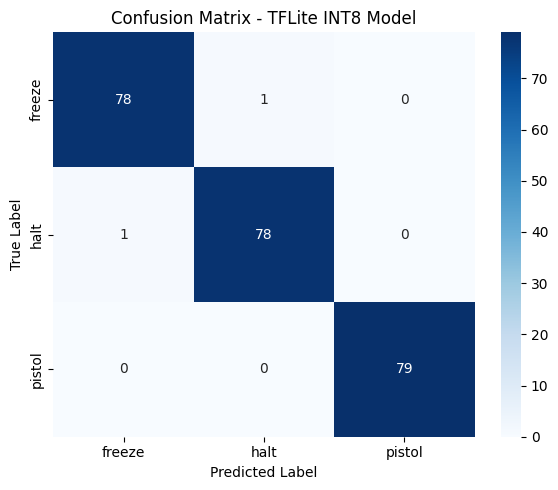

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true   # true labels
y_pred   # predicted labels

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(val_generator.class_indices.keys()),
    yticklabels=list(val_generator.class_indices.keys())
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TFLite INT8 Model")
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))


[[78  1  0]
 [ 1 78  0]
 [ 0  0 79]]
              precision    recall  f1-score   support

      freeze       0.99      0.99      0.99        79
        halt       0.99      0.99      0.99        79
      pistol       1.00      1.00      1.00        79

    accuracy                           0.99       237
   macro avg       0.99      0.99      0.99       237
weighted avg       0.99      0.99      0.99       237



In [23]:
from google.colab import files
files.download("hand_signal_int8.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>